In [64]:
import pandas as pd
pd.set_option('display.max_columns', 250)

import numpy as np

from scipy.sparse import coo_matrix, csr_matrix, hstack

import seaborn as sns
import matplotlib.pyplot as plt

#imputers
from impyute.imputation.cs import mice, fast_knn 
from sklearn.impute import SimpleImputer 

#encoders
import category_encoders as ce

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier


import itertools
import pickle



In [2]:
#################ДОБАВИТЬ STANDARD SCALER!!!!#################################

In [3]:
SEED = 42

In [4]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## Загрузка данных

In [5]:
churn_data = pd.read_csv('./Data/orange_small_churn_data.txt')
# churn_data.head()

In [6]:
churn_labels = np.loadtxt('./Data/orange_small_churn_labels.txt').astype('int')
churn_labels = np.reshape(churn_labels, (40000, 1))
churn_data['label'] = churn_labels > 0 #convert (-1, 1) to (True, False)

In [7]:
churn_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,label
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.0,600.0,NaN,20.0,480.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,82752.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.907926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,NaN,NaN,716008.0,NaN,0.0,NaN,NaN,14599.92,NaN,5.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,NaN,144.0,-1209960.0,NaN,NaN,NaN,NaN,NaN,1660.0,NaN,NaN,NaN,66.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0.0,326915.0,604276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,389396.0,NaN,NaN,NaN,2313888.0,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,599532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,NaN,EkHG,9_Y1,k13i,09_Q,IYzP,GjJ35utlTa_GNSvxxpb9ju,kIsH,NaN,uKAI,L84s,JBfYVit4g8,NaN,NaN,NaN,TDctq2l,KmRo,cJvF,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,False
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,NaN,NaN,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.0,265.0,NaN,2.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2706120.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.870327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,128,0.0,NaN,1661128.0,NaN,0.0,NaN,NaN,67529.09,NaN,25.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,72.0,417932.0,NaN,NaN,NaN,NaN,NaN,1025.0,NaN,NaN,NaN,66.0,NaN,24912.0,40.0,NaN,NaN,NaN,NaN,NaN,0.0,1934460.0,349568.0,NaN,NaN,NaN,NaN,NaN,205.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,735.0,NaN,NaN,NaN,6502680.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,364182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,NaN,JDd6,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,I_mbgcr,NaN,XTbqizz,qMoY,cJvF,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,False
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,NaN,NaN,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,220.0,NaN,0.0,72.0,NaN,NaN,311.76,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4698780.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.981628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0

In [8]:
churn_data.shape

(40000, 231)

Первые 190 признаков - числовые, остальные 40 - категориальные.

## Подготовка данных

### Отбор признаков по колчеству пропущенных значений

Определим, есть ли в датафрейме полностью пустые столбцы. 

In [9]:
const_feature = churn_data.isna().sum(axis = 0) == len(churn_data)
useless_features = const_feature[const_feature == True].index
print('Полностью пустые признаки: \n', useless_features.to_list())

Полностью пустые признаки: 
 ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


In [10]:
num_features_names = ['Var{}'.format(i) for i in range(1, 191) if 'Var{}'.format(i) not in useless_features]
cat_features_names = ['Var{}'.format(i) for i in range(191, 231) if 'Var{}'.format(i) not in useless_features]

print('Количество числовых признаков:', len(num_features_names))
print('Количество категориальных признаков:', len(cat_features_names))

Количество числовых признаков: 174
Количество категориальных признаков: 38


In [11]:
num_data = churn_data.loc[:, num_features_names]
cat_data = churn_data.loc[:, cat_features_names]

**Подберем порог отбрасывания числовых признаков по количеству пустых объектов**

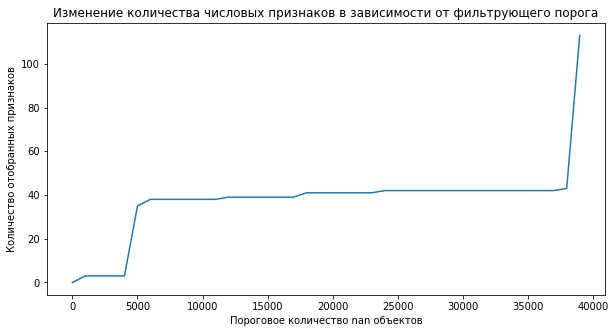

In [12]:
feature_amount = []
for threshold in range(0, 40000, 1000):
    nan_counter = num_data.isna().sum(axis = 0)
    f_amount = len(nan_counter[nan_counter < threshold])
    feature_amount.append(f_amount)

plt.figure(figsize = (10, 5))
plt.plot(range(0, 40000, 1000), feature_amount)
plt.title('Изменение количества числовых признаков в зависимости от фильтрующего порога')
plt.xlabel('Пороговое количество nan объектов')
plt.ylabel('Количество отобранных признаков')
plt.show()

In [13]:
NUM_THRESHOLD = 25000

In [14]:
nan_count = num_data.isna().sum(axis = 0).to_frame(name = 'count')
useful_num_featues = nan_count[nan_count['count'] < NUM_THRESHOLD].index

num_data = num_data[useful_num_featues]

In [15]:
print('Итоговое количество отобранных числовых признаков:', num_data.shape[1])

Итоговое количество отобранных числовых признаков: 42


**Аналогично подберем порог для категориальных признаков**

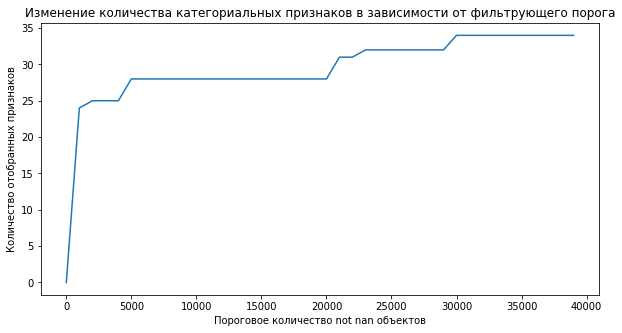

In [16]:
feature_amount = []
for threshold in range(0, 40000, 1000):
    nan_counter = cat_data.isna().sum(axis = 0)
    f_amount = len(nan_counter[nan_counter < threshold])
    feature_amount.append(f_amount)

plt.figure(figsize = (10, 5))
plt.plot(range(0, 40000, 1000), feature_amount)
plt.title('Изменение количества категориальных признаков в зависимости от фильтрующего порога')
plt.xlabel('Пороговое количество not nan объектов')
plt.ylabel('Количество отобранных признаков')
plt.show()

Обработаем все категориальные признаки

### Разбиение данных

In [17]:
full_data = pd.concat([num_data, cat_data, churn_data['label']], axis = 1)
full_data.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,label
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,0.0,2.907926,NaN,NaN,34,NaN,716008.0,0.0,14599.92,5.0,32.0,NaN,144.0,144.0,-1209960.0,1660.0,66.0,NaN,4.0,0.0,326915.0,604276.0,NaN,0.0,9.0,389396.0,2313888.0,28.0,599532.0,0.0,0.0,NaN,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,NaN,EkHG,9_Y1,k13i,09_Q,IYzP,GjJ35utlTa_GNSvxxpb9ju,kIsH,uKAI,L84s,JBfYVit4g8,NaN,NaN,NaN,TDctq2l,KmRo,cJvF,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,False
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,0.0,5.870327,27.0,3.0,128,0.0,1661128.0,0.0,67529.09,25.0,10.0,32289.0,80.0,72.0,417932.0,1025.0,66.0,24912.0,40.0,0.0,1934460.0,349568.0,205.0,0.0,18.0,735.0,6502680.0,14.0,364182.0,0.0,0.0,276.0,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,NaN,JDd6,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,NaN,I_mbgcr,NaN,XTbqizz,qMoY,cJvF,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,False
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,0.0,5.981628,18.0,3.0,166,245.0,3025152.0,0.0,85266.00,35.0,0.0,53388.0,40.0,48.0,-124655.2,590.0,78.0,7218.0,36.0,0.0,3148410.0,1086210.0,400.0,0.0,27.0,0.0,10569040.0,18.0,0.0,0.0,0.0,NaN,NaN,FoxgUHSK8h,LrdZy8QqgUfkVShG,NaN,taul,1K8T,TyGl,fhk21Ss,nQUveAzAF7,NaN,NaN,dnwD,9_Y1,mTeA,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,uKAI,L84s,4kVnq_T26xq1p,NaN,NaN,NaN,pMWBUmQ,qLXr,UYBR,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,False
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,0.0,5.108097,9.0,NaN,30,0.0,2642240.0,0.0,74107.20,10.0,2.0,NaN,32.0,32.0,378473.6,1435.0,24.0,693.0,NaN,8.0,7066700.0,650390.0,5.0,0.0,0.0,0.0,9676200.0,108.0,253284.0,0.0,0.0,NaN,NaN,vNEvyxLp3Z,RO12,NaN,taul,1K8T,0Xwj,uoZk2Zj,LWyxgtXeJL,NaN,NaN,CwmB,F3hy,vzJD,VpdQ,IYzP,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,JC0e,cJvF,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,True
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,0.0,0.650716,9.0,3.0,32,0.0,1440.0,0.0,171072.90,25.0,12.0,106455.0,32.0,8.0,142602.4,490.0,60.0,468.0,-28.0,0.0,3794460.0,642816.0,225.0,0.0,9.0,554414.0,10535200.0,24.0,2851284.0,0.0,0.0,NaN,NaN,4e7gUH7IEC,RO12,NaN,taul,1K8T,vSNn,kugYdIL,ZIXKpoNpqq,NaN,NaN,625Z,9_Y1,m_h1,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,NGZXfGp,064o,cJvF,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,False


In [18]:
num_col_names = num_data.columns
cat_col_names = cat_data.columns

print('Число сырых числовых признаков', len(num_col_names))
print('Число сырых категориальных признаков', len(cat_col_names))

Число сырых числовых признаков 42
Число сырых категориальных признаков 38


In [19]:
X = full_data.drop(columns = ['label'])
y = full_data['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

y_train = y_train.values
y_test = y_test.values

### Подбор  методов запонения пропусков в данных

Обзор стратегий заполнения: 
* https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
* https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e

Подходы для числовых данных:
* Simple imputer from sklearn
* [MICE (Multivariate imputation by chained equations)](https://impyute.readthedocs.io/en/latest/index.html)
* [DataWig](https://datawig.readthedocs.io/en/latest/source/userguide.html#step-by-step-examples) - *Слишком долго*
* [kNN](https://impyute.readthedocs.io/en/master/api/cross_sectional_imputation.html#impyute.imputation.cs.fast_knn)

Подходы для категориальных данных:
* [kNN](https://impyute.readthedocs.io/en/master/api/cross_sectional_imputation.html#impyute.imputation.cs.fast_knn)
* [Simple imputer with most frequent value](https://github.com/scikit-learn-contrib/sklearn-pandas#categoricalimputer)
* fillna + дополнительный признак

#### Числовые данные

**Simple mean imputer**

In [20]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_train_num_mean = imp.fit_transform(X_train_raw[num_col_names])
X_test_num_mean = imp.transform(X_test_raw[num_col_names])

X_train_num_mean = pd.DataFrame(X_train_num_mean, columns = num_col_names)
X_test_num_mean = pd.DataFrame(X_test_num_mean, columns = num_col_names)

In [21]:
print(X_train_num_mean.shape)
print(X_test_num_mean.shape)

(32000, 42)
(8000, 42)


In [22]:
print(X_train_num_mean.isnull().sum().sum())
print(X_test_num_mean.isnull().sum().sum())

0
0


**MICE**

In [23]:
# How MICE works: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

#Alternative realization in statsmodels
# https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICE.html
# MICE statsmodel using examples: https://programtalk.com/vs2/python/12423/statsmodels/statsmodels/imputation/tests/test_mice.py/

In [24]:
# %%time
## Не дождался
# X_train_num_mice = mice(X_train_raw[num_col_names])
# X_test_num_mice = mice(X_test_raw[num_col_names])

**DataWig**

In [25]:
# # Очень долго, обрабатывается по одному столбцу за итерацию
# X_train_num_dw = None
# X_test_num_dw = None

**kNN (fast-Knn from impyute)**

In [26]:
# %%time
# #10 min
# X_train_num_knn = fast_knn(X_train_raw[num_col_names], k = 5)
# X_test_num_knn = fast_knn(X_test_raw[num_col_names], k = 5)

# X_train_num_knn.to_csv('./Data/X_train_num_knn', index_label = False)
# X_test_num_knn.to_csv('./Data/X_test_num_knn', index_label = False)

/home/grigoriy/.local/lib/python3.6/site-packages/impyute/util/preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()


CPU times: user 10min 8s, sys: 776 ms, total: 10min 9s
Wall time: 10min 10s


In [27]:
X_train_num_knn = pd.read_csv('./Data/X_train_num_knn')
X_test_num_knn = pd.read_csv('./Data/X_test_num_knn')

In [28]:
print(X_train_num_knn.shape)
print(X_test_num_knn.shape)

(32000, 42)
(8000, 42)


In [29]:
print(X_train_num_knn.isnull().sum().sum())
print(X_test_num_knn.isnull().sum().sum())

0
0


#### Категориальные данные

**kNN**

In [30]:
# Article: https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
# Code implementation: https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850

In [31]:
# X_train_cat_knn = None 
# X_test_cat_knn = None 

**Categorical imputer**

In [32]:
imp = DataFrameImputer()
X_train_cat_freq = imp.fit_transform(X_train_raw[cat_col_names]).reset_index(drop = True)
X_test_cat_freq = imp.transform(X_test_raw[cat_col_names]).reset_index(drop = True)

In [33]:
print(X_train_cat_freq.shape)
print(X_test_cat_freq.shape)

(32000, 38)
(8000, 38)


In [34]:
print(X_train_cat_freq.isnull().sum().sum())
print(X_test_cat_freq.isnull().sum().sum())

0
0


**Fillna + additional feature**

In [35]:
def fillna_imputer(df):
    column_names = df.columns.to_list()
    result = pd.DataFrame()
    for name in column_names:
#         print(name)
        result[name] = df[name].fillna(value = 'Nan')
        result[name + '_bool'] = df[name].isna()
    return result.reset_index(drop = True)

In [36]:
X_train_cat_fillna = fillna_imputer(X_train_raw[cat_col_names])
X_test_cat_fillna = fillna_imputer(X_test_raw[cat_col_names])

In [37]:
print(X_train_cat_fillna.shape)
print(X_test_cat_fillna.shape)

(32000, 76)
(8000, 76)


In [38]:
print(X_train_cat_fillna.isnull().sum().sum())
print(X_test_cat_fillna.isnull().sum().sum())

0
0


#### Генерирование наборов данных с различными стратегиями заполнения. Кодирование

In [39]:
num_data_dict = {'mean': (X_train_num_mean, X_test_num_mean), 
                 'knn': (X_train_num_knn, X_test_num_knn)}
cat_data_dict = {'freq': (X_train_cat_freq , X_test_cat_freq),
                 'fillna': (X_train_cat_fillna, X_test_cat_fillna)}

In [40]:
#Cоберем в словарь типа key: (train, test) различные комбинации числовых/категориальных данных

data_dict = {}

for keys_combination in itertools.product( list(num_data_dict.keys()), list(cat_data_dict.keys())):
    print(keys_combination)
    data_dict[keys_combination[0] + '_' + keys_combination[1]] = (pd.concat([num_data_dict[keys_combination[0]][0],
                                                                                cat_data_dict[keys_combination[1]][0]], axis = 1),
                                                                      pd.concat([num_data_dict[keys_combination[0]][1],
                                                                                cat_data_dict[keys_combination[1]][1]], axis = 1)
                                                                     )                                                                    


('mean', 'freq')
('mean', 'fillna')
('knn', 'freq')
('knn', 'fillna')


In [41]:
data_dict.keys()

dict_keys(['mean_freq', 'mean_fillna', 'knn_freq', 'knn_fillna'])

In [42]:
print(data_dict['mean_freq'][0].shape)
print(data_dict['mean_freq'][1].shape)

(32000, 80)
(8000, 80)


Использование разных моделей обучения подразумевает  различные варианты кодирования категориальных данных.<br> Для логистической регресси воспользуемся One-Hot encoding, для нелинейных моделей используем CatBoostEncoder. 

В дальнейшем, после определения оптимального входного датасета, подберем опитмальный способ кодирования категориальных признаков.

In [43]:
data_encoders_dict = {}

In [44]:
# ohe_encoder = ce.OneHotEncoder(return_df=False) # Не влезает в память, напишем функцию вручную

Подготовим набор данных для линейных моделей (One Hot Encoding)

In [45]:
print('Типы данных в наборах:', data_dict['mean_freq'][0].dtypes.unique())

Типы данных в наборах: [dtype('float64') dtype('O')]


In [46]:
def make_csr_ohe(x_train, x_test, columns):
    '''
    Function provide OneHot encoding of selected columns from mixed (categorical and non-categorical) dataframe.
    Return X_train, X_test in csr format and columns names.
    '''
    # Sanity index drop
    x_train = x_train.reset_index(drop = True)
    x_test = x_test.reset_index(drop = True)
    
    x_full = pd.concat([x_train, x_test], axis = 0)
    
    print('Nan values amount:', x_full.isnull().sum().sum())
    
    # Categorical data to coo matrix + make columns labels
    x_str = x_full.select_dtypes(exclude = ['float64'])
    x_str_ohe = pd.get_dummies(x_str, sparse = True, drop_first = True, columns = columns)
    ohe_labels = x_str_ohe.columns.to_list()
    x_str_ohe = x_str_ohe.sparse.to_coo()
    
    # Numerical data to coo matrix + make columns labels
    x_num = coo_matrix(x_full.select_dtypes(include = ['float64']))
    num_labels = x_full.select_dtypes(include = ['float64']).columns.to_list()
    
    column_names = num_labels + ohe_labels
    
    # Make final matrixm convert from coo to csr
    x_full = csr_matrix(hstack([x_num, x_str_ohe]))
    x_train = x_full[:x_train.shape[0] ,:]
    x_test = x_full[x_train.shape[0]: ,:]

    return (x_train, x_test, column_names)
    
    

In [47]:
%%time
data_ohe_dict = {}
for key in data_dict.keys():
    print(key)
    X_train, X_test = data_dict[key]
    ohe_columns = X_train.select_dtypes(exclude = ['float64']).columns.to_list()
    data_ohe_dict[key] = make_csr_ohe(X_train, X_test, ohe_columns)

mean_freq
Nan values amount: 0
mean_fillna
Nan values amount: 0
knn_freq
Nan values amount: 0
knn_fillna
Nan values amount: 0
CPU times: user 1min 16s, sys: 589 ms, total: 1min 16s
Wall time: 1min 17s


In [48]:
data_encoders_dict['ohe'] = data_ohe_dict

Подготовим набор для нелинейных моделей (CatBoost Encoding)

In [49]:
%%time
data_catboost_dict = {}
for key in data_dict.keys():
    print(key)
    X_train, X_test = data_dict[key]
    column_names = X_train.columns.to_list()
    catboost_columns = X_train.select_dtypes(exclude = ['float64']).columns.to_list()
    catboost_encoder = ce.CatBoostEncoder(cols = catboost_columns, random_state = SEED)
    X_train = catboost_encoder.fit_transform(X_train, y_train)
    X_test = catboost_encoder.transform(X_test)
    data_catboost_dict[key] = (X_train, X_test, column_names)

mean_freq
mean_fillna
knn_freq
knn_fillna
CPU times: user 16.9 s, sys: 132 ms, total: 17 s
Wall time: 17.1 s


In [50]:
data_encoders_dict['catboost'] = data_catboost_dict

In [51]:
# # Сохраним результаты в pkl файл
# # https://stackoverflow.com/questions/7100125/storing-python-dictionaries

# with open('./Data/data_dict.pkl', 'wb') as file:
#     pickle.dump(data_encoders_dict, file, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('./Data/data_dict.pkl', 'rb') as file:
#     data_encoders_dict = pickle.load(file)

#### Выбор оптимального набора даных для различных моделей

In [75]:
def train_model_cv_cl(X_train, y_train, X_test, params, 
                      encoder = None, 
                      model_type = 'sklearn', eval_metric = 'auc', 
                      sk_model = None, 
                      n_folds = 5,
                      n_estimators = 1000,
                      n_jobs = -1,
                      verbose = 250,
                      early_stopping_rounds = 200
                     ):
    if encoder is not None:
        X_train = encoder.fit_transform(X_train, y_train)
        X_test = encoder.transform(X_test)
    
    # set up scoring parameters for different models
    metrics_dict = {'auc': {'lgb': 'auc',         
                            'cat': 'AUC',
                            'sklearn': metrics.roc_auc_score,
                            'xgb': 'auc'}  
                   }
    cv_scores = []
    result_dict = {}
    pred_test = np.zeros(X_test.shape[0])
    pred_train = np.zeros(X_train.shape[0]) #collect all validation predictions over all folds
    
    fold_method = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = SEED)
    for fold_n, (dev_index, val_index) in enumerate(fold_method.split(X_train, y_train)):
        try: #if data scr or numpy matrices
            X_dev, X_val = X_train[dev_index], X_train[val_index]
            y_dev, y_val = y_train[dev_index], y_train[val_index]
            
        except: #if x data is pandas dataframes
            X_dev, X_val = X_train.iloc[dev_index], X_train.iloc[val_index]
            y_dev, y_val = y_train[dev_index], y_train[val_index]
              
        if model_type == 'sklearn':
            model = sk_model(**params)
            model.fit(X_dev, y_dev)
            pred_y_val = model.predict_proba(X_val)[:, 1]
            pred_y_test = model.predict_proba(X_test)[:, 1]
            
            score = metrics_dict[eval_metric][model_type](y_val, pred_y_val)
            print(f'Fold {fold_n}. {eval_metric}: {score:.6f}.')
            #print('')
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_dev, y_dev, eval_set = [(X_val, y_val)], 
                      eval_metric = metrics_dict[eval_metric][model_type],
                      verbose=verbose, 
                      early_stopping_rounds=early_stopping_rounds)
            pred_y_val = model.predict_proba(X_val)[:, 1]
            pred_y_test = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            dev_data = xgb.DMatrix(data = X_dev, label = y_dev)
            valid_data = xgb.DMatrix(data = X_val, label = y_val)            
            watchlist = [(dev_data, 'dev_data'), (valid_data, 'valid_data')]
            
            param = params #outside parameters
            param['eval_metric'] = metrics_dict[eval_metric][model_type] #add parameter from metric_dict
            
            model = xgb.train(dtrain = dev_data, evals=watchlist,
                              num_boost_round = n_estimators, 
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=verbose, params=params)            
            pred_y_val = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
            pred_y_test = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric][model_type], **params,
                                      loss_function='Logloss', od_wait = early_stopping_rounds)
            model.fit(X_dev, y_dev, eval_set=(X_val, y_val), use_best_model=True, verbose=verbose)
            pred_y_val = model.predict_proba(X_val)[:, 1]
            pred_y_test = model.predict_proba(X_test)[:, 1]
            
        
        pred_train[val_index] += pred_y_val
        pred_test += pred_y_test
        cv_scores.append(metrics_dict[eval_metric]['sklearn'](y_val, pred_y_val))
        
    pred_test /= n_folds
    result_dict['predictions'] = pred_test
    result_dict['overall_val_predictions'] = pred_y_val
    result_dict['cv_scores'] = cv_scores
    
    print('CV mean score: {0:.6f}, std: {1:.6f}.'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    return result_dict

##### Линейные модели

Линейные модели есть смысл запускать как на  ohe, так и на catboost комплектах данных

###### LogisticRegression

In [401]:
logistic_model_dict = {}

In [413]:
for key in data_encoders_dict['ohe'].keys():
    print(key)
    X_train, X_test, column_names = data_encoders_dict['ohe'][key]
    linear_model_dict['ohe_' + key] = train_model_cv_cl(X_train, y_train, X_test, 
                                                        model_type = 'sklearn', eval_metric = 'auc', 
                                                        sk_model = LogisticRegression,
                                                        params = {'solver': 'lbfgs', 
                                                                  'max_iter': 1000, 
                                                                  'n_jobs': -1}) 
    print('------------------------------------------')

mean_freq
Fold 0. auc: 0.572987.
Fold 1. auc: 0.575455.
Fold 2. auc: 0.555308.
Fold 3. auc: 0.565902.
Fold 4. auc: 0.561178.
CV mean score: 0.566166, std: 0.007425.
------------------------------------------
mean_fillna
Fold 0. auc: 0.569056.
Fold 1. auc: 0.576553.
Fold 2. auc: 0.555852.
Fold 3. auc: 0.564231.
Fold 4. auc: 0.561392.
CV mean score: 0.565417, std: 0.007019.
------------------------------------------
knn_freq
Fold 0. auc: 0.570664.
Fold 1. auc: 0.569773.
Fold 2. auc: 0.556045.
Fold 3. auc: 0.563669.
Fold 4. auc: 0.563349.
CV mean score: 0.564700, std: 0.005275.
------------------------------------------
knn_fillna
Fold 0. auc: 0.566847.
Fold 1. auc: 0.577704.
Fold 2. auc: 0.556560.
Fold 3. auc: 0.564108.
Fold 4. auc: 0.562707.
CV mean score: 0.565585, std: 0.006934.
------------------------------------------


In [431]:
for key in data_encoders_dict['catboost'].keys():
    print(key)
    X_train, X_test, column_names = data_encoders_dict['catboost'][key]
    linear_model_dict['catboost_' + key] = train_model_cv_cl(X_train, y_train, X_test, 
                                                        model_type = 'sklearn', eval_metric = 'auc', 
                                                        sk_model = LogisticRegression,
                                                        params = {'solver': 'lbfgs', 
                                                                  'max_iter': 1000, 
                                                                  'n_jobs': -1}) 
    print('------------------------------------------')

mean_freq
Fold 0. auc: 0.571325.
Fold 1. auc: 0.576987.
Fold 2. auc: 0.554452.
Fold 3. auc: 0.568617.
Fold 4. auc: 0.560658.
CV mean score: 0.566408, std: 0.007962.
------------------------------------------
mean_fillna
Fold 0. auc: 0.573205.
Fold 1. auc: 0.574827.
Fold 2. auc: 0.556447.
Fold 3. auc: 0.565541.
Fold 4. auc: 0.562336.
CV mean score: 0.566471, std: 0.006835.
------------------------------------------
knn_freq
Fold 0. auc: 0.567728.
Fold 1. auc: 0.568266.
Fold 2. auc: 0.555030.
Fold 3. auc: 0.562598.
Fold 4. auc: 0.561102.
CV mean score: 0.562945, std: 0.004845.
------------------------------------------
knn_fillna
Fold 0. auc: 0.571258.
Fold 1. auc: 0.577834.
Fold 2. auc: 0.555448.
Fold 3. auc: 0.561860.
Fold 4. auc: 0.563450.
CV mean score: 0.565970, std: 0.007780.
------------------------------------------


Для логистической регресии оптимальной оказалась стратегия CatBoost encoding + mean_fillna imputing

###### SVM (SVC)

SVM (SVC)

In [53]:
LinearSVC_model_dict = {}

In [55]:
#Linear SVC doesn`t support 'predict_proba'

# for key in data_encoders_dict['ohe'].keys():
#     print(key)
#     X_train, X_test, column_names = data_encoders_dict['ohe'][key]
#     SVM_model_dict['ohe_' + key] = train_model_cv_cl(X_train, y_train, X_test, 
#                                                         model_type = 'sklearn', eval_metric = 'auc', 
#                                                         sk_model = LinearSVC,
#                                                         params = {'random_state': SEED,                          
#                                                                   'class_weight': 'balanced'}) 
#     print('------------------------------------------')

##### Нелинейные модели

###### Random Forest Classifier

In [61]:
random_forest_dict = {}

In [62]:
for key in data_encoders_dict['catboost'].keys():
    print(key)
    X_train, X_test, column_names = data_encoders_dict['catboost'][key]
    random_forest_dict['catboost_' + key] = train_model_cv_cl(X_train, y_train, X_test, 
                                                        model_type = 'sklearn', eval_metric = 'auc', 
                                                        sk_model = RandomForestClassifier,
                                                        params = {'n_estimators': 250, 
                                                                  'class_weight': 'balanced', 
                                                                  'n_jobs': -1}) 
    print('------------------------------------------')

mean_freq
Fold 0. auc: 0.706151.
Fold 1. auc: 0.691666.
Fold 2. auc: 0.712462.
Fold 3. auc: 0.682030.
Fold 4. auc: 0.670996.
CV mean score: 0.692661, std: 0.015215.
------------------------------------------
mean_fillna
Fold 0. auc: 0.705970.
Fold 1. auc: 0.692666.
Fold 2. auc: 0.710045.
Fold 3. auc: 0.701861.
Fold 4. auc: 0.689302.
CV mean score: 0.699969, std: 0.007852.
------------------------------------------
knn_freq
Fold 0. auc: 0.687546.
Fold 1. auc: 0.685533.
Fold 2. auc: 0.694057.
Fold 3. auc: 0.675955.
Fold 4. auc: 0.678551.
CV mean score: 0.684328, std: 0.006480.
------------------------------------------
knn_fillna
Fold 0. auc: 0.691187.
Fold 1. auc: 0.700344.
Fold 2. auc: 0.706647.
Fold 3. auc: 0.695220.
Fold 4. auc: 0.676725.
CV mean score: 0.694025, std: 0.010080.
------------------------------------------


###### CatBoost Classifier

In [65]:
catboost_dict = {}

In [76]:
for key in data_encoders_dict['catboost'].keys():
    print(key)
    X_train, X_test, column_names = data_encoders_dict['catboost'][key]
    catboost_dict['catboost_' + key] = train_model_cv_cl(X_train, y_train.astype('int'), X_test, 
                                                        model_type = 'cat', eval_metric = 'auc', 
                                                        params = {}) 
    print('------------------------------------------')

mean_freq
Learning rate set to 0.109677
0:	test: 0.5441244	best: 0.5441244 (0)	total: 12.5ms	remaining: 12.5s
250:	test: 0.7315613	best: 0.7439121 (115)	total: 2.24s	remaining: 6.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7439120544
bestIteration = 115

Shrink model to first 116 iterations.
Learning rate set to 0.109677
0:	test: 0.5392342	best: 0.5392342 (0)	total: 8.76ms	remaining: 8.75s
250:	test: 0.7399689	best: 0.7450266 (123)	total: 2.26s	remaining: 6.74s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.74502664
bestIteration = 123

Shrink model to first 124 iterations.
Learning rate set to 0.109677
0:	test: 0.5312167	best: 0.5312167 (0)	total: 10.2ms	remaining: 10.2s
250:	test: 0.7305633	best: 0.7352774 (74)	total: 2.28s	remaining: 6.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7352774499
bestIteration = 74

Shrink model to first 75 iterations.
Learning rate set to 0.109677
0:	test: 0.5397583	best: 0.5397

Лучше всего показал себя градиентный бустинг с применением mean_fillna кодирования.